# Health Survey Data Analysis

Michelle Radcliffe

## Executive Summary

The goal of this notebook is to analyze some data of study participants' physical health and evaluate if there is statistical significance in health between those who rent vs buy their home.

## The Data

The data on the .csv file being accessed comes from the <a href=https://www.cdc.gov/brfss/annual_data/2020/pdf/codebook20_llcp-v2-508.pdf>CDC Behavioral Risk Factor Surveillance System (BRFSS)</a>. This subset of the data represents survey responses from the 2020-2021 survey in the state of New York. Each record represents a survey response.

The two columns that will be cleaned are:<br>
<li>'PHYSHLTH' which asks "for how many days during the past 30 days was your physical health not good?" (units: 0-30 days)</li>
<li>'RENTHOM1' which asks "do you own or rent your home?" (1 or 2)</li>

First, we will import the necessary libraries and open our .csv file.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
%matplotlib inline


file_path = "https://raw.githubusercontent.com/learn-co-curriculum/da-phase3-project-enterprise/main/brfss_ny.csv"
df = pd.read_csv(file_path)

## Data Preparation

There is not a lot that needs to be done for preparing/cleaning the data. The codebook that we are given has a 'legend' which assigns numbers to values. 'PHYHLTH' is concerned with the number of days (1-30) that participants felt physically ill/injured in the month. The other values that do not fall under 1-30 are:<br>
<br>
<li>88 = None</li>
<li>77 = Don't know/not sure</li>
<li>99 = Refused</li>
<li>BLANK = Not asked or missing</li><br>
Let's take a quick look at how many entries there are of each and then decide how to handle them.

In [2]:
len(df['PHYSHLTH']) # total length of 'PHYSHLTH' = 14769

14769

In [3]:
df['PHYSHLTH'].nunique()

33

In [4]:
df['PHYSHLTH'].loc[df['PHYSHLTH'] == 88]; # 'None' total length = 10565

In [5]:
df['PHYSHLTH'].loc[df['PHYSHLTH'] == 77]; # 'Don't know/not sure' total length = 248

In [6]:
df['PHYSHLTH'].loc[df['PHYSHLTH'] == 99]; # 'Refused' total length = 81

In [7]:
df['PHYSHLTH'].isna().sum() # There are no BLANK entries that need to be dropped.

0

Let's replace values 88 with 0 because 88 represents 'None' or, numerically, 0.<br>
Then, after replacing values 77 and 99 with 'NaN', we will drop them because they account for only 329 values of 14769. They will not have a significant impact on the data after being dropped.

In [8]:
df['PHYSHLTH'] = df['PHYSHLTH'].replace(to_replace=88, value=0)
df['PHYSHLTH'] = df['PHYSHLTH'].replace(to_replace=77, value='NaN')
df['PHYSHLTH'] = df['PHYSHLTH'].replace(to_replace=99, value='NaN')
df = df.drop(df[df['PHYSHLTH'] == 'NaN'].index)

Now our column is all integers 0-30.

In [9]:
df['PHYSHLTH'].unique()

array([0.0, 14.0, 5.0, 2.0, 3.0, 10.0, 30.0, 20.0, 1.0, 7.0, 15.0, 25.0,
       8.0, 4.0, 21.0, 6.0, 29.0, 9.0, 28.0, 18.0, 24.0, 17.0, 12.0, 13.0,
       16.0, 26.0, 27.0, 23.0, 19.0, 11.0, 22.0], dtype=object)

Now that the 'PHYSHLTH' column is clean, we will look at the 'RENTHOM1' column which tells us which participants rent or own their home. The answers in this column are:<br>
<br>
<li>1 = Own</li>
<li>2 = Rent</li>
<li>3 = Other arrangement</li>
<li>7 = Don't know/not sure</li>
<li>9 = Refused</li>
<li>BLANK = Not asked or Missing</li><br>
Let's clean this data so we only have two options, 1 or 2. It is not necessary, but let's look at the total numbers of each entry.

In [10]:
len(df['RENTHOM1']) # Remember we dropped some rows for PHYSHLTH so our dataframe only has 14440 total entries

14440

In [11]:
df['RENTHOM1'].loc[df['RENTHOM1'] == 3]; # Total length 585

In [12]:
df['RENTHOM1'].loc[df['RENTHOM1'] == 7]; # Total length 55

In [13]:
df['RENTHOM1'].loc[df['RENTHOM1'] == 9]; # Total length 141

In [14]:
df['RENTHOM1'].isna().sum() # There are no missing values

0

I will drop entries with 3, 7, and 9.

In [15]:
df['RENTHOM1'] = df['RENTHOM1'].replace(to_replace=3, value='NaN')
df['RENTHOM1'] = df['RENTHOM1'].replace(to_replace=7, value='NaN')
df['RENTHOM1'] = df['RENTHOM1'].replace(to_replace=9, value='NaN')
df = df.drop(df[df['RENTHOM1'] == 'NaN'].index)

In [16]:
df['RENTHOM1'].unique()

array([2.0, 1.0], dtype=object)

In [17]:
len(df['RENTHOM1'])

13659

It looks like our data is ready to be worked with. Let's investigate.

## Confidence Interval for Mean of `PHYSHLTH`

Let's calculate the sample mean and standard error of ['PHYSHLTH'] to find the confidence interval using an alpha of .05.

In [18]:
sample = df['PHYSHLTH']
n = len(sample)
sample_mean = np.mean(sample)
sample_std = np.std(sample)
z = stats.norm.ppf(0.95)
se = sample_std/np.sqrt(n)
alpha = .05
print('Mean: ', sample_mean)
print('Standard Deviation: ', sample_std)
print('Z-score: ', z)
print('Standard error: ', se)

Mean:  3.064646020938575
Standard Deviation:  7.581047638533649
Z-score:  1.6448536269514722
Standard error:  0.06486639662011313


In [19]:
stats.t.interval(alpha=1-alpha, loc=sample_mean, scale=se, df=n-1)

(2.9374989520675534, 3.1917930898095968)

Using these sample parameters, we found a confidence interval of (2.937, 3.192). Remember that we are looking at the number of days that participants felt physically ill/injured. This means that we can say we are 95% confident that the unknown true population mean of participants who felt ill falls somewhere between 2.937 and 3.192 days.  

## Differences in `PHYSHLTH` Based on `RENTHOM1`

### How Does `PHYSHLTH` Differ Based on `RENTHOM1`?

In this section we will split the dataset (<b>df</b>) into two separate dataframes: <b>df_own</b> for home owners and <b>df_rent</b> for those who rent. This way we can look at the differences in each groups physical health and decide whether or not there is a statistically significant result.

In [20]:
df_rent = df.loc[df['RENTHOM1'] == 2]
df_rent.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_RFPSA23,_CLNSCPY,_SGMSCPY,_SGMS10Y,_RFBLDS4,_STOLDNA,_VIRCOLN,_SBONTIM,_CRCREC1,_AIDTST4
0,36,11,11172020,11,17,2020,1200,2020000001,2020000001,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,36,4,5042020,5,4,2020,1200,2020000003,2020000003,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,36,3,3102020,3,10,2020,1200,2020000005,2020000005,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
5,36,7,7162020,7,16,2020,1200,2020000006,2020000006,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
6,36,8,8102020,8,10,2020,1200,2020000007,2020000007,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df_own = df.loc[df['RENTHOM1'] == 1]
df_own.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_RFPSA23,_CLNSCPY,_SGMSCPY,_SGMS10Y,_RFBLDS4,_STOLDNA,_VIRCOLN,_SBONTIM,_CRCREC1,_AIDTST4
1,36,1,1182020,1,18,2020,1200,2020000002,2020000002,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
13,36,1,3102020,3,10,2020,1200,2020000014,2020000014,NaN,...,NaN,1.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,2.0
15,36,1,5132020,5,13,2020,1200,2020000016,2020000016,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
20,36,1,9192020,9,19,2020,1200,2020000021,2020000021,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
23,36,10,12022020,12,2,2020,1200,2020000024,2020000024,NaN,...,2.0,1.0,2.0,2.0,2.0,3.0,3.0,2.0,1.0,1.0


Now that we have the datasets split into home owners and renters we can plot their distributions to see how comparable these datasets are and from there we can calculate if there is statistical significance.

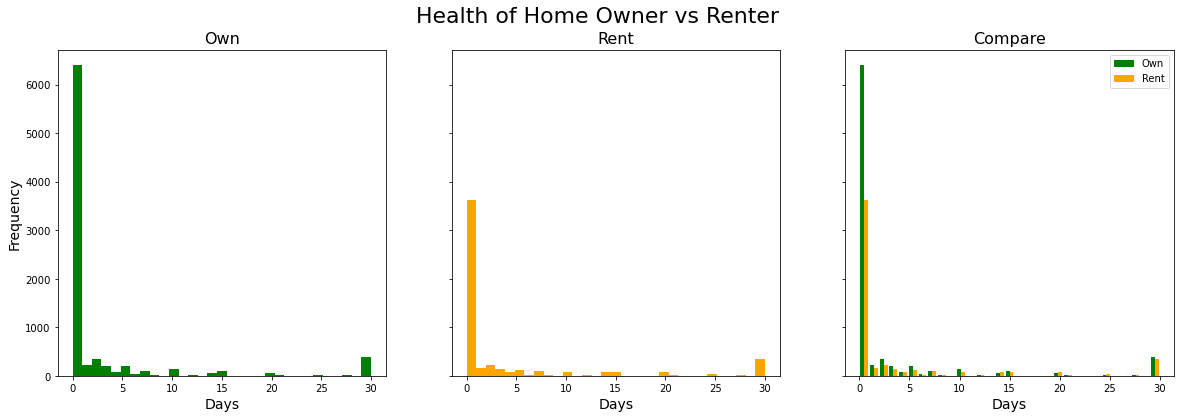

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

fig.suptitle('Health of Home Owner vs Renter', fontsize=22)

own_health = df_own['PHYSHLTH']
rent_health = df_rent['PHYSHLTH']

axes[0].hist(own_health, color='green', bins=31)
axes[0].set_title('Own', fontsize=16)
axes[0].set_xlabel('Days', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=14)

axes[1].hist(rent_health, color='orange', bins=31)
axes[1].set_title('Rent', fontsize=16)
axes[1].set_xlabel('Days', fontsize=14)

axes[2].hist([own_health, rent_health], color=['green', 'orange'], bins=31)
axes[2].set_title('Compare', fontsize=16)
axes[2].set_xlabel('Days', fontsize=14)
axes[2].legend(['Own', 'Rent']);

In order from left to right, the above plots show the distributions of physical health of home owners, renters, and the same graphs plotted in an overlay. At a glance, it appears that a much larger amount of home owners (6400) did not feel ill/injured more days of the month than renters (3600) which may be significant. However, the results for the remaining days appear fairly insignificant. Let's investigate further to see what the numbers tell us.

### Is the Difference Statistically Significant?

Now that we have a better understanding of what the data is showing us, we can run a t-test to determine whether or not there is a statistical significance between either dataset. Our first step is to oficially state our null and alternative hypotheses:<br>
<br>
The null hypothesis ($H_0$): there is not a statistically significant difference in physical health between renters and home owners.<br>
<br>
<center>$H_0$ = $H_a$</center>

The alternative hypothesis ($H_a$): there is a statistically significant difference in physical health between renters and home owners.<br>
<br>
<center>$H_0 \neq H_a$</center>
<br>
Our experiment is considered a two-tailed test because we are not trying to attain a direction ($>$ or $<$) in which way the tests are related but only to understand if the tests have any kind of relationship in either direction (= or $ \neq $). We cannot conclusively say that there is a statistically significant difference, yet. We will find the t-statistic and p-value and relate them back to alpha (.05).

In [23]:
result = stats.ttest_ind(own_health, rent_health, axis=0, equal_var=True)
t_stat, p_value = result
print('T-statistic: ', result[0])
print('P-value: ', result[1])
print('p < .05')
print('We can reject the null hypothesis.')

T-statistic:  -7.653280527933751
P-value:  2.0902050539402288e-14
p < .05
We can reject the null hypothesis.


Based on the statistics, the p-value is calculated at about 2.09e-14 which is significantly smaller than our alpha of .05. This means that we can <b>reject the null hypothesis</b> and accept our alternative hypothesis stating that there is a significant relationship in physical health between home owners and renters.

## Next Steps

This was a good experiment to find if home owning or renting is related to physical health. What other aspects of the CDC codebook could we investigate further to find a correlation or causation? One of the columns that I would be interested in exploring deeper is 'ALCDAY5' which asks participants how many days of the month they drank an alcoholic beverage. I would then compare this data to the amount of days felt physically ill/injured. 

The values in 'ALCDAY5' are expressed as days per week <i>and</i> days per month. Since the 'PHYSHLTH' column is only days per month, I would convert days per week into days per month. I would account for the other answer values in this column the same as in 'PHYSHLTH' by dropping the rows 'refused', 'missing', or 'don't know/not sure' and relabeling 'no drinks in the past 30 days' as 0 instead of 888. Next, I would state a null hypothesis and alternative hypothesis which would be a little different than what the previous experiment because it would probably be more of a one-tailed experiment. So I could say that:<br>
<center>$H_0$: the amount of days felt ill by those who drank more is no different than the amount of days felt ill by those who drank less.<br>
    $H_a$: the amount of days felt ill by those who drank more is <b>significantly more</b> than the amount of days felt ill by those who drank less.</center><br>
Then, plot two graphs to compare, calculate the t-statistic and p-value to find if, and finally compare the p-value to alpha and conclude if they are statistically significant. From there I could use other columns in the CDC codebook that look into the amounts that participants drank varying from light to 'binge'.

## Summary
In this notebook I compared two columns of a dataset. First, I explored and cleaned both columns. Then, I used scipy's stats module to find the confidence interval of the mean of one of the columns which I then interpreted. Next, I split the original datasets into two separate datasets which I plotted and interpreted. I executed a t-test by first stating the null and alternative hypotheses then found the t-statistic and p-value determining that the null hypothesis could be rejected. Finally, I chose another column in the CDC codebook and described a plan of how I would investigate it.